In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [49]:
class Clas(nn.Module):
    def __init__(self, in_channels, hs1=128, hs2=64, hs3=32, out=10):
        super(Clas, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hs1, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hs1, hs2, 3, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hs2, hs3, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hs3, out, 3, stride=1, padding=1),
            # nn.Softmax(dim=1)
        )


    def forward(self, x):
        y = self.layers(x)
        return y.mean(dim=(2,3))
    

    def fit(self, train, val, epochs):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=self.parameters(), lr=1e-3)

        losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_val_loss = 0
            self.train()
            for batch in (bar:=tqdm(train)):
                x = batch[0]
                y = batch[1]

                preds = self(x)
                loss = loss_fn(preds, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss+=loss.item()
                bar.set_description(f"Epoch {epoch+1}/{epochs}, loss: {loss.item():.4f}")

            self.eval()
            with torch.no_grad():
                for batch in val:
                    x_val = batch[0]
                    y_val = batch[1]
                    preds_val = self(x_val) 
                    val_loss = loss_fn(preds_val, y_val)    
                    epoch_val_loss += val_loss.item()  

                print(f'Loss: {epoch_loss/len(train)}, Val_loss: {epoch_val_loss/len(val)}')         



In [42]:
train_set = MNIST(root='./data', train=True,  download=True, transform=None)
test_set = MNIST(root='./data', train=False,  download=True, transform=None)

In [43]:
type(train_set)

torchvision.datasets.mnist.MNIST

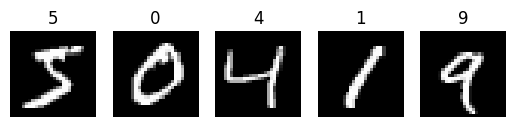

In [44]:
for i in range(5):
    image, number = train_set[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='grey')
    plt.axis('off')
    plt.title(f'{number}')

plt.show()

In [45]:
to_tensor = transforms.ToTensor()

#
X_train = [to_tensor(im) for im, num in train_set]
y_train = [num for im, num in train_set]

X_test = [to_tensor(im) for im, num in test_set]
y_test = [num for im, num in test_set]


#
X_train_tensor = torch.stack(X_train)
y_train_tensor = torch.tensor(y_train, dtype= torch.long)

X_test_tensor = torch.stack(X_test)
y_test_tensor = torch.tensor(y_test, dtype= torch.long)

In [46]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [47]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor[5000:], y_test_tensor[5000:])
test_dataset = TensorDataset(X_test_tensor[:5000], y_test_tensor[:5000])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [51]:
model = Clas(in_channels=1)
model.fit(train_loader, val_loader, 6)

Epoch 1/6, loss: 0.3917: 100%|██████████| 3750/3750 [01:17<00:00, 48.36it/s]


Loss: 0.5318035227390627, Val_loss: 0.17655193221163207


Epoch 2/6, loss: 0.0570: 100%|██████████| 3750/3750 [01:16<00:00, 48.74it/s]


Loss: 0.20000389890484513, Val_loss: 0.10279184647132092


Epoch 3/6, loss: 0.1836: 100%|██████████| 3750/3750 [01:18<00:00, 47.73it/s]


Loss: 0.1510728815991121, Val_loss: 0.08243316823740106


Epoch 4/6, loss: 0.0348: 100%|██████████| 3750/3750 [01:17<00:00, 48.15it/s]


Loss: 0.1272103547307973, Val_loss: 0.06419164680532914


Epoch 5/6, loss: 0.0074: 100%|██████████| 3750/3750 [01:18<00:00, 47.58it/s]


Loss: 0.10863282449133695, Val_loss: 0.060646977329447405


Epoch 6/6, loss: 0.0168: 100%|██████████| 3750/3750 [01:18<00:00, 47.95it/s]


Loss: 0.09743533832839069, Val_loss: 0.10846242052261174


In [53]:
all_preds = []
all_trues = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x)
        prediction = torch.argmax(outputs, dim=1)
        all_preds.extend(prediction.numpy())
        all_trues.extend(y.numpy())

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       460
           1       0.96      0.99      0.98       571
           2       0.89      0.98      0.94       530
           3       0.97      0.95      0.96       500
           4       0.94      0.99      0.96       500
           5       0.82      0.99      0.90       456
           6       0.98      0.95      0.96       462
           7       0.98      0.95      0.96       512
           8       0.99      0.83      0.90       489
           9       0.98      0.92      0.95       520

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



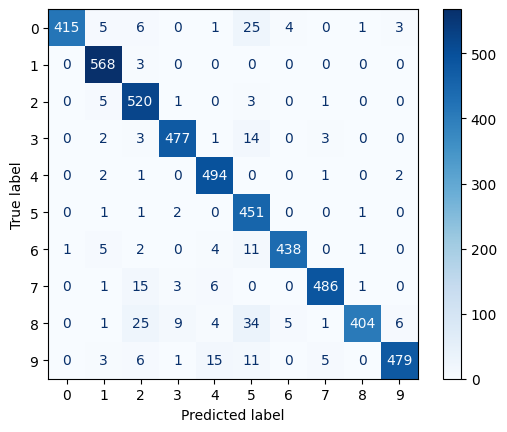

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(all_trues, all_preds))

cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

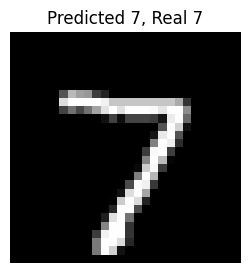

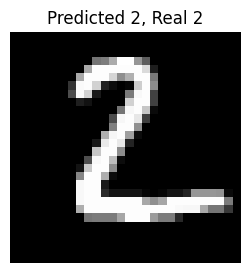

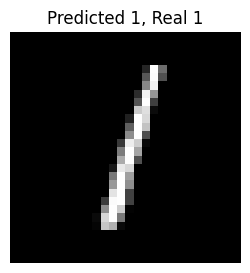

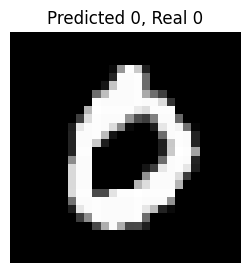

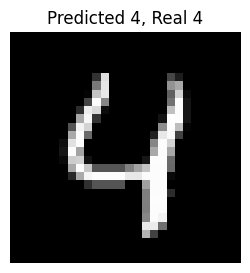

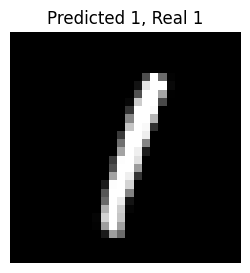

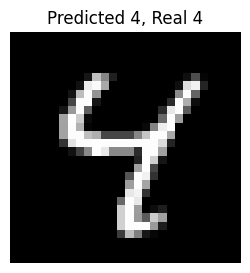

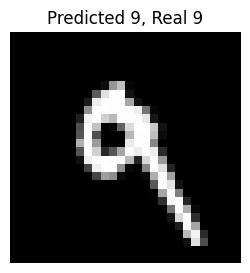

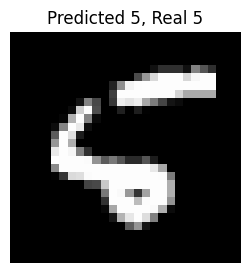

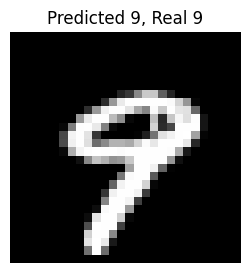

In [61]:
for i in range(10):
    # plt.subplot(1, 10,)
    img, num = test_set[i]
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='grey')
    plt.axis('off')
    plt.title(f'Predicted {all_preds[i]}, Real {all_trues[i]}')
    plt.show()